# Brian Sohn, bs3358

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

In [2]:
data = pd.read_csv("data.csv")
data

,Unnamed: 0,user_no,gender,age_grp,number_of_ads_served,number_of_sucessful_impressions
0,0,0,0,5,1,0
1,1,1,1,0,10,1
2,2,2,0,0,10,1
3,3,3,0,0,1,0
4,4,4,0,4,8,0
...,...,...,...,...,...,...
995,995,995,0,1,1,0
996,996,996,0,3,6,0
997,997,997,1,2,8,2
998,998,998,1,5,1,0


### Creating Dummy Variables for age_grp

In [3]:
dummies = pd.get_dummies(data.age_grp, prefix='age_grp', drop_first=True)
df = pd.concat([data, dummies], axis=1)
df['constant']=1
df = df[['constant', 'gender', 'age_grp_1', 'age_grp_2', 'age_grp_3', 'age_grp_4', 'age_grp_5', 'number_of_ads_served', 'number_of_sucessful_impressions']]
df

,constant,gender,age_grp_1,age_grp_2,age_grp_3,age_grp_4,age_grp_5,number_of_ads_served,number_of_sucessful_impressions
0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,10,1
2,1,0,0,0,0,0,0,10,1
3,1,0,0,0,0,0,0,1,0
4,1,0,0,0,0,1,0,8,0
...,...,...,...,...,...,...,...,...,...
995,1,0,1,0,0,0,0,1,0
996,1,0,0,0,1,0,0,6,0
997,1,1,0,1,0,0,0,8,2
998,1,1,0,0,0,0,1,1,0


### Create Pymc Model to Estimate Parameters

Model: f ~ Bin(n,p) where $p = \frac{1}{1+exp(-p_0)}$,  $p_0$ ~ N($X\beta$,1), $\beta$~N(0,1)

In [4]:
model = pm.Model()

with model:
    beta = pm.Normal('beta', mu=0, sigma=1, size=7)
    p_0 = pm.Normal('p_0', mu=pm.math.dot(df.iloc[:,:7], beta), sigma=1)
    p = pm.Deterministic('p', 1 / (1 + pm.math.exp(-1 * p_0)))
    
    X_obs = pm.Binomial('X_obs', n=df['number_of_ads_served'], p=p, observed=df['number_of_sucessful_impressions'])
    
    idata=pm.sample()
    pm.sample_posterior_predictive(idata,extend_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, p_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.


### Results

In [5]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-3.334,0.167,-3.640,-3.016,0.008,0.005,481.0,1133.0,1.01
beta[1],1.057,0.126,0.839,1.309,0.004,0.003,852.0,1654.0,1.01
beta[2],0.231,0.219,-0.172,0.647,0.010,0.007,497.0,1166.0,1.01
beta[3],0.546,0.209,0.132,0.908,0.009,0.007,511.0,900.0,1.01
beta[4],0.664,0.211,0.277,1.065,0.008,0.005,779.0,1595.0,1.00
...,...,...,...,...,...,...,...,...,...
p[995],0.060,0.060,0.002,0.162,0.001,0.001,3912.0,3089.0,1.00
p[996],0.061,0.049,0.001,0.151,0.001,0.001,4418.0,2773.0,1.00
p[997],0.211,0.104,0.047,0.411,0.002,0.001,3743.0,2600.0,1.00
p[998],0.171,0.122,0.010,0.401,0.002,0.001,3934.0,2977.0,1.00


<AxesSubplot: xlabel='X_obs / X_obs'>

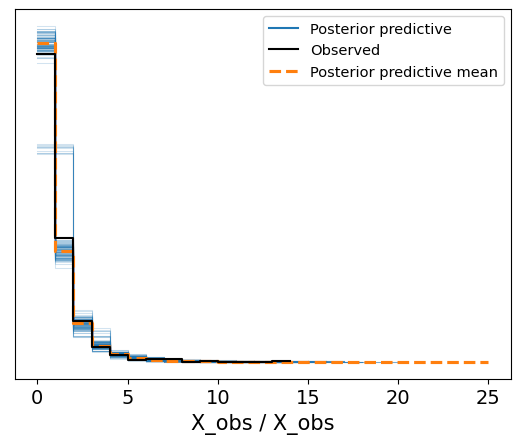

In [7]:
az.plot_ppc(idata, num_pp_samples=100) # looks like our model fits pretty well!

In [10]:
# coefficients for beta.
beta_values = np.array(idata.posterior.beta.mean(axis=0).mean(axis=0))
beta_df = pd.DataFrame(beta_values)
beta_df.index = df.columns[:7]
beta_df.columns = ['Coefficient']
beta_df.round(2)

,Coefficient
constant,-3.33
gender,1.06
age_grp_1,0.23
age_grp_2,0.55
age_grp_3,0.66
age_grp_4,0.92
age_grp_5,0.60


In [11]:
# each individual's success probability can be accessed using p.
probs = np.array(idata.posterior.p.mean(axis=0).mean(axis=0))
probs_df = pd.DataFrame(probs)
probs_df.columns = ['Probability of Success']
probs_df.round(3)

,Probability of Success
0,0.080
1,0.107
2,0.064
3,0.050
4,0.065
...,...
995,0.060
996,0.061
997,0.211
998,0.171
